# Thermal

gdsfactory has an FEM plugin that you can use for thermal simulations.

In [1]:
import gmsh
import gdsfactory as gf
from gdsfactory.simulation.gmsh.mesh import create_physical_mesh
from gdsfactory.simulation.thermal import solve_thermal
from gdsfactory.generic_tech import get_generic_pdk
from gdsfactory.technology import LayerStack, LayerLevel
import meshio
from skfem.io import from_meshio

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

gf.generic_tech.LAYER_STACK.layers["heater"].thickness = 0.13
gf.generic_tech.LAYER_STACK.layers["heater"].zmin = 2.2

heater = gf.components.straight_heater_metal(length=50, heater_width=2)
heater

2023-02-20 17:59:05.790 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.43.1


2023-02-20 17:59:07.179 | INFO     | gdsfactory.technology.layer_views:__init__:785 - Importing LayerViews from YAML file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/layer_views.yaml.


2023-02-20 17:59:07.186 | INFO     | gdsfactory.pdk:activate:206 - 'generic' PDK is now active


AppLayout(children=(Tab(children=(VBox(children=(HBox(children=(Button(layout=Layout(border_bottom='solid 2px …

straight_heater_metal_u_ca170410: uid 974da837, ports ['o1', 'o2', 'e1', 'e2'], references ['component_sequence_1', 'via_stack_1', 'via_stack_2', 'taper_1', 'taper_2'], 0 polygons


In [2]:
print(gf.generic_tech.LAYER_STACK.layers.keys())

dict_keys(['substrate', 'box', 'core', 'clad', 'slab150', 'slab90', 'nitride', 'ge', 'undercut', 'via_contact', 'metal1', 'heater', 'via1', 'metal2', 'via2', 'metal3'])


In [3]:
filtered_layerstack = LayerStack(
    layers={
        k: gf.pdk.get_layer_stack().layers[k]
        for k in (
            "slab90",
            "core",
            "via_contact",
            'heater'
        )
    }
)

In [4]:
filename = "mesh"

def mesh_with_physicals(mesh, filename):
    mesh_from_file = meshio.read(f"{filename}.msh")
    return create_physical_mesh(mesh_from_file, "triangle", prune_z=True)

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[]

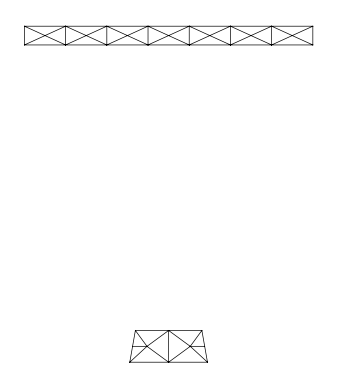

In [5]:
mesh = heater.to_gmsh(
    type="uz",
    xsection_bounds=[(4, -4), (4, 4)],
    layer_stack=filtered_layerstack,
    filename=f"{filename}.msh",
)
mesh = mesh_with_physicals(mesh, filename)
mesh = from_meshio(mesh)
mesh.draw().plot()

FIXME!

```python

solve_thermal(
    mesh_filename="mesh.msh",
    thermal_conductivity={"heater": 28, "oxide": 1.38, "core": 148},
    specific_conductivity={"heater": 2.3e6},
    thermal_diffusivity={
        "heater": 28 / 598 / 5240,
        "oxide": 1.38 / 709 / 2203,
        "core": 148 / 711 / 2330,
    },
    # specific_heat={"(47, 0)_0": 598, 'oxide': 709, '(1, 0)': 711},
    # density={"(47, 0)_0": 5240, 'oxide': 2203, '(1, 0)': 2330},
    currents={"heater": 0.007},
)
```

Example based on [femwell](https://helgegehring.github.io/femwell/index.html)

In [6]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio
from tqdm import tqdm

from femwell.mesh import mesh_from_OrderedDict
from femwell.mode_solver import compute_modes, plot_mode
from femwell.thermal import solve_thermal

/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


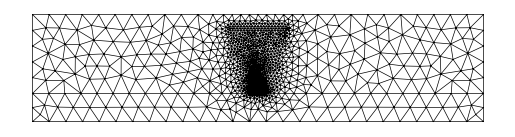

In [7]:
w_sim = 8 * 2
h_clad = 2.8
h_box = 1
w_core = 0.5
h_core = 0.22
offset_heater = 2.2
h_heater = 0.14
w_heater = 2

polygons = OrderedDict(
    bottom=LineString([(-w_sim / 2, -h_core / 2 - h_box), (w_sim / 2, -h_core / 2 - h_box)]),
    core=Polygon(
        [
            (-w_core / 2, -h_core / 2),
            (-w_core / 2, h_core / 2),
            (w_core / 2, h_core / 2),
            (w_core / 2, -h_core / 2),
        ]
    ),
    heater=Polygon(
        [
            (-w_heater / 2, -h_heater / 2 + offset_heater),
            (-w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, h_heater / 2 + offset_heater),
            (w_heater / 2, -h_heater / 2 + offset_heater),
        ]
    ),
    clad=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2 + h_clad),
            (w_sim / 2, -h_core / 2),
        ]
    ),
    box=Polygon(
        [
            (-w_sim / 2, -h_core / 2),
            (-w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2 - h_box),
            (w_sim / 2, -h_core / 2),
        ]
    ),
)

resolutions = dict(
    core={"resolution": 0.04, "distance": 1},
    clad={"resolution": 0.6, "distance": 1},
    box={"resolution": 0.6, "distance": 1},
    heater={"resolution": 0.1, "distance": 1},
)

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6))
mesh.draw().show()